# Notes

In [46]:
import numpy as np
import json as js
import pandas as pd

import seaborn as sns
%matplotlib inline

from jupyterthemes import jtplot
import matplotlib.pyplot as plt

jtplot.style()

#jtplot.style(theme='onedork')
#jtplot.reset()

def dar_grupo_usuario(s , num_modules = 20):
    return(abs(ord(s[0]) + ord(s[1]) + ord(s[-1])) % (num_modules))

In [47]:
%%javascript

IPython.tab_as_tab_everywhere = function(use_tabs) {
    if (use_tabs === undefined) {
        use_tabs = true; 
    }

    // apply setting to all current CodeMirror instances
    IPython.notebook.get_cells().map(
        function(c) {  return c.code_mirror.options.indentWithTabs=use_tabs;  }
    );
    // make sure new CodeMirror instances created in the future also use this setting
    CodeMirror.defaults.indentWithTabs=use_tabs;

    };

IPython.tab_as_tab_everywhere()

<IPython.core.display.Javascript object>

## Pipeline
Construye un modelo para cada ciudad y lo guarda

In [11]:
num_modules = 20

### Extracción de Categorías
Crea un diccionario con todos los negocios de la ciudad

In [12]:
total = 0
with open('data_raw/yelp_dataset/yelp_academic_dataset_business.json', 'r') as f:
    total = len(f.readlines())


step = int(np.round(0.1*total))


# Diccionario de lugares
locations = {}
negocios = {}

    
with open('data_raw/yelp_dataset/yelp_academic_dataset_business.json', 'r') as f:
    categories = {}
    locations = {}
    i = 0
    for line in f.readlines():
        line = line.strip()
        obj = js.loads(line)
        cat = obj['categories']
        
        if obj['state'] is not None and cat is not None:
            loc = obj['state']
            
            if loc not in locations:
                locations[loc] = {}
                locations[loc]['total'] = 0
                locations[loc]['business_id'] = []
                locations[loc]['category'] = []
            
            locations[loc]['total'] += 1
        
            for c in cat.split(','):
                locations[loc]['business_id'].append(obj['business_id'])
                locations[loc]['category'].append(c)
            
        if cat is not None:
            negocios[obj['business_id']] = cat.split(',')
            
            
        if i%step == 0:
            print('{}%'.format(np.round(100*i/total,2)))
        
        i += 1

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


### Itera Por Ciudad

In [13]:
final_dict = {}
final_dict['OTHER'] = {}
final_dict['OTHER']['total'] = 0
final_dict['OTHER']['business_id'] = []
final_dict['OTHER']['category'] = []
others = []

for k in locations:
    if locations[k]['total'] > 100:
        final_dict[k] = locations[k]
    else:
        others.append(k)
        final_dict['OTHER']['total']  += locations[k]['total']
        final_dict['OTHER']['business_id']  += locations[k]['business_id']
        final_dict['OTHER']['category']  += locations[k]['category']

print('Others: ' + str(others))
final_locations = list(final_dict.keys())
final_locations

Others: ['CA', 'TX', 'NY', 'CO', 'XWY', 'GA', 'BC', 'YT', 'HPL', 'AL', 'UT', 'VT', 'WA', 'NE', 'DOW', 'MI', 'FL', 'AR', 'HI', 'MB', 'OR', 'AK', 'VA', 'CT', 'MO', 'DUR']


['OTHER', 'NC', 'AZ', 'QC', 'NV', 'IL', 'ON', 'AB', 'PA', 'WI', 'SC', 'OH']

In [14]:
total_negocios = []
total_categorias = []

print('Inicia Construcción de los modelos de contenido por ciudad')

for i in range(len(final_locations)):
    
    loc = final_locations[i]
    
    print('   {} ({} de {})'.format(loc, i + 1, len(final_locations)))
    # Extrae los valores
    neg = final_dict[loc]['total']
    print('      Total Negocios: {}'.format(neg))

    ids = final_dict[loc]['business_id']
    categories = final_dict[loc]['category']

    # Crea la matriz
    df = pd.DataFrame({'business_id':ids, 'feature_id': categories, 'count':1})
    matriz = pd.pivot_table(df, values = 'count', index=['business_id'],columns=['feature_id'], aggfunc=np.sum)
    matriz.fillna(0, inplace = True)

    matriz_inicial = matriz.shape
    print('      Matriz Inicial: {}'.format(matriz_inicial))
    
    cat = matriz_inicial[1]
	
	# Crea la matrid idf
    #features = matriz.sum()
    #idf = np.log2(matriz.shape[0]/features)
    #matriz_idf = matriz.multiply(idf, axis=1)
	
	
    # Guarda la matriz
    matriz.to_pickle('data/content_models_by_state/{}.zip'.format(loc))
    
    print()
    
    total_negocios.append(neg)
    total_categorias.append(cat)
    
    

    
resultados = pd.DataFrame({'ciudad':final_locations, 'total_negocios':total_negocios, 'total_categorias':total_categorias})
resultados.to_csv('resumen_ciudad.csv'.format(loc))

Inicia Construcción de los modelos de contenido por ciudad
   OTHER (1 de 12)
      Total Negocios: 91
      Matriz Inicial: (91, 214)

   NC (2 de 12)
      Total Negocios: 16182
      Matriz Inicial: (16182, 1804)

   AZ (3 de 12)
      Total Negocios: 60642
      Matriz Inicial: (60642, 2281)

   QC (4 de 12)
      Total Negocios: 10210
      Matriz Inicial: (10210, 1212)

   NV (5 de 12)
      Total Negocios: 38986
      Matriz Inicial: (38986, 2201)

   IL (6 de 12)
      Total Negocios: 2028
      Matriz Inicial: (2028, 984)

   ON (7 de 12)
      Total Negocios: 36540
      Matriz Inicial: (36540, 1765)

   AB (8 de 12)
      Total Negocios: 8661
      Matriz Inicial: (8661, 1346)

   PA (9 de 12)
      Total Negocios: 12346
      Matriz Inicial: (12346, 1677)

   WI (10 de 12)
      Total Negocios: 5517
      Matriz Inicial: (5517, 1446)

   SC (11 de 12)
      Total Negocios: 1325
      Matriz Inicial: (1325, 806)

   OH (12 de 12)
      Total Negocios: 16341
      Matriz Inic

In [7]:
resultados

,ciudad,total_negocios,total_categorias
0,OTHER,91,214
1,NC,16182,1804
2,AZ,60642,2281
3,QC,10210,1212
4,NV,38986,2201
5,IL,2028,984
6,ON,36540,1765
7,AB,8661,1346
8,PA,12346,1677
9,WI,5517,1446


Text(0.5, 1.0, 'Distribución de Negocios por Categorias (Montreal-QC)')

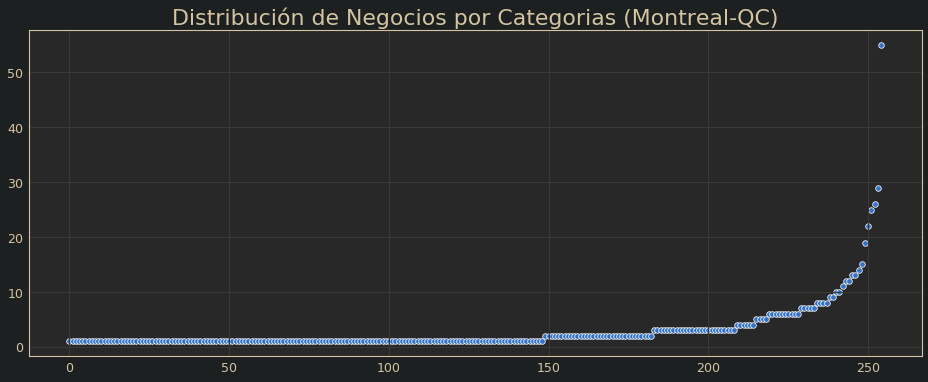

In [11]:
# Guarda las imagenes
features = matriz.sum()
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(range(0,len(features)) ,features.sort_values() )
ax.set_title('Distribución de Negocios por Categorias ({})'.format(loc), fontsize=22)


Text(0.5, 1.0, 'Distribución de Categorias por Negocio (Montreal-QC)')

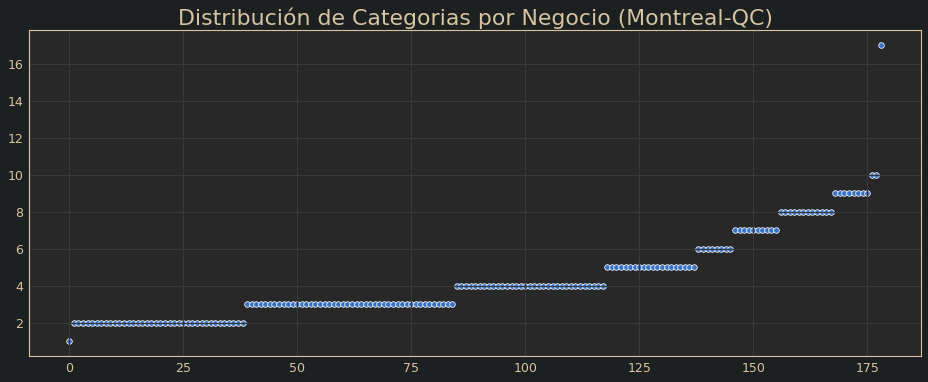

In [12]:
business = matriz.sum(axis = 1)
plt.figure(figsize=(16, 6))
ax = sns.scatterplot(range(0,len(business)) ,business.sort_values() )
ax.set_title('Distribución de Categorias por Negocio ({})'.format(loc), fontsize=22)

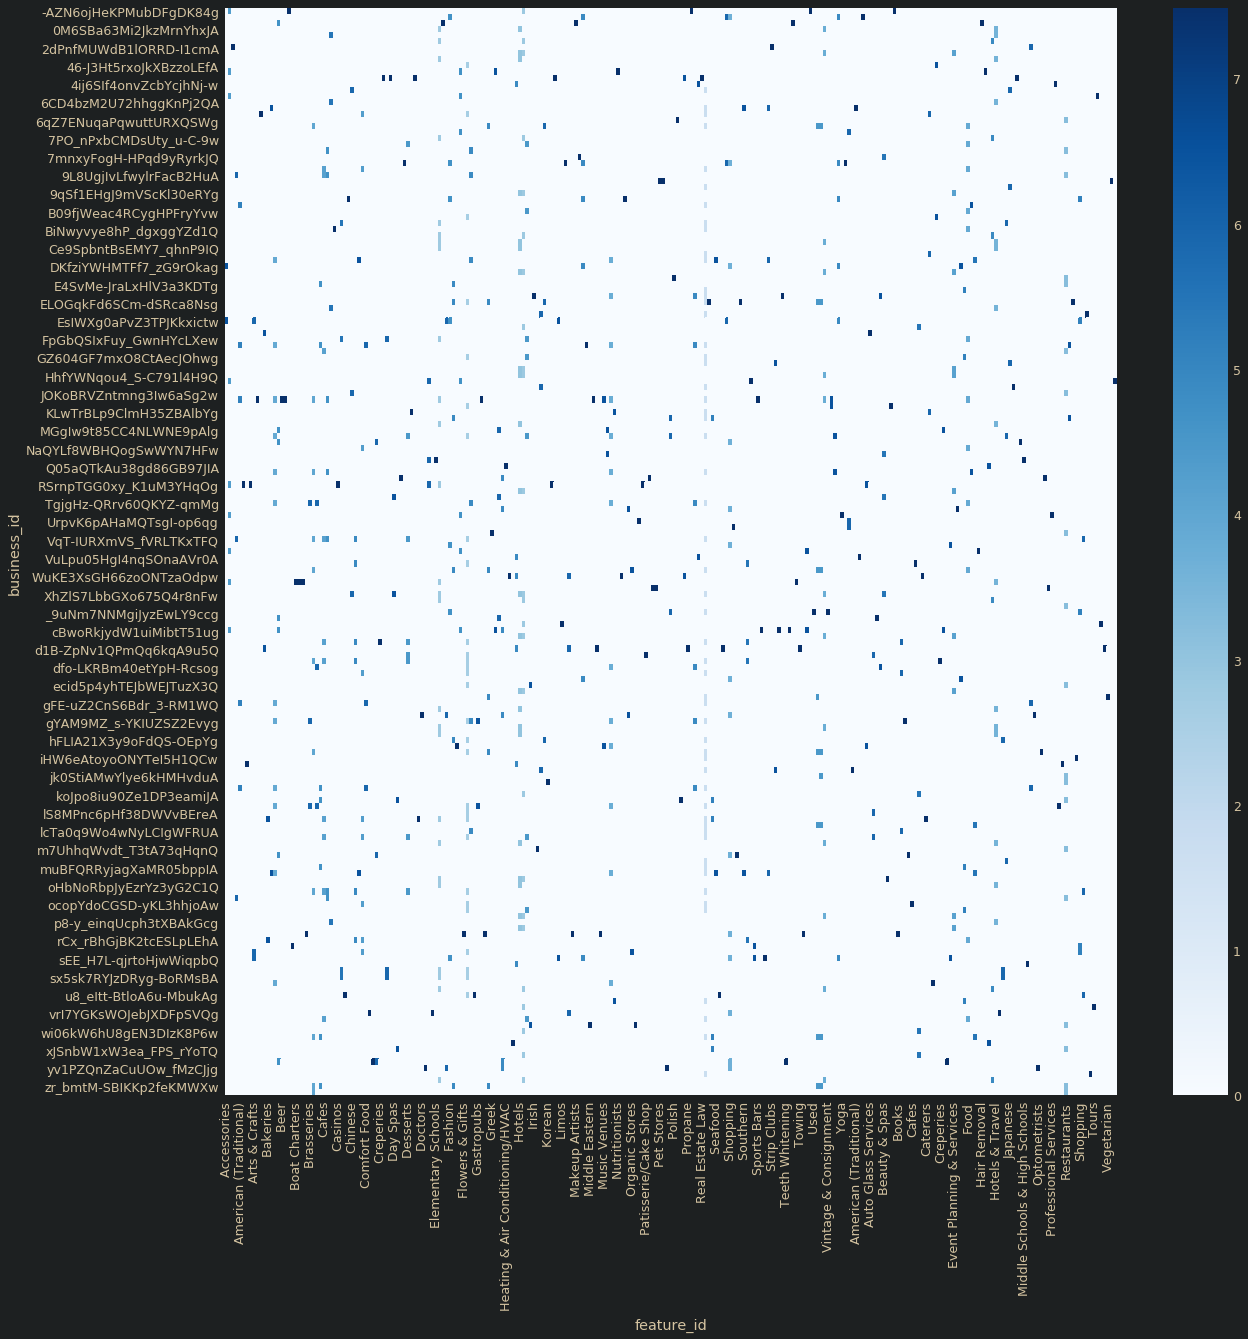

In [28]:
plt.figure(figsize=(20, 20))
sns.heatmap(matriz_idf ,cmap="Blues", vmin=0)

### Construccion Preferencias Usuarios

In [8]:
import json
import glob
import pandas as pd

num_modules = 20

In [10]:
def construct_profile(df):
        
    profile = {}
    for ind, row in df.iterrows():
        b_id = row.business_id
        
        if b_id in negocios:
            for c in negocios[b_id]:
                if c not in profile:
                    profile[c] = 0
                profile[c] += row.stars
    
    res = pd.Series({'profile': str(profile)})
    return(res)


for m in range(num_modules):
    
    print('Started With: {} of {}'.format(m + 1, num_modules))

    df_review = pd.read_pickle('data_raw/CF_base_formato_json_grouped/reviews_{}.zip'.format(m))
    df_review.groupby('user_id').apply(construct_profile).to_pickle('data/user_content_profiles/group_{}.zip'.format(m))
    

Started With: 1 of 20
Started With: 2 of 20
Started With: 3 of 20
Started With: 4 of 20
Started With: 5 of 20
Started With: 6 of 20
Started With: 7 of 20
Started With: 8 of 20
Started With: 9 of 20
Started With: 10 of 20
Started With: 11 of 20
Started With: 12 of 20
Started With: 13 of 20
Started With: 14 of 20
Started With: 15 of 20
Started With: 16 of 20
Started With: 17 of 20
Started With: 18 of 20
Started With: 19 of 20
Started With: 20 of 20


## Promedio de los Lugares

In [42]:
# Guarda las calificaciones promedio de cada lugar

df = None

for m in range(num_modules):
    
    df_review = pd.read_pickle('data_raw/CF_base_formato_json_grouped/reviews_{}.zip'.format(m))
    
    df_fil = df_review[['business_id','stars']].groupby('business_id').agg(['sum','size'])
    df_fil.columns = df_fil.columns.droplevel()
    
    if df is None:
        df = df_fil
    else:
        df = pd.concat((df.reset_index(),df_fil.reset_index()), ignore_index = True).groupby('business_id').sum()
        
    print('Done with {} of {} (num rows: {})'.format(m+1, num_modules, df.shape[0]))

df['avg_rating'] = df['sum']/df['size']
df.to_pickle('data/avg_business_ratings/avg_ratings.zip')
df

Done with 1 of 20 (num rows: 99163)
Done with 2 of 20 (num rows: 132805)
Done with 3 of 20 (num rows: 153927)
Done with 4 of 20 (num rows: 168306)
Done with 5 of 20 (num rows: 178643)
Done with 6 of 20 (num rows: 186471)
Done with 7 of 20 (num rows: 192931)
Done with 8 of 20 (num rows: 197356)
Done with 9 of 20 (num rows: 200616)
Done with 10 of 20 (num rows: 203216)
Done with 11 of 20 (num rows: 205041)
Done with 12 of 20 (num rows: 206491)
Done with 13 of 20 (num rows: 207535)
Done with 14 of 20 (num rows: 208259)
Done with 15 of 20 (num rows: 208777)
Done with 16 of 20 (num rows: 209095)
Done with 17 of 20 (num rows: 209270)
Done with 18 of 20 (num rows: 209361)
Done with 19 of 20 (num rows: 209388)
Done with 20 of 20 (num rows: 209393)


,sum,size,avg_rating
business_id,,,
--1UhMGODdWsrMastO9DZw,109.0,27,4.037037
--6MefnULPED_I942VcFNA,159.0,55,2.890909
--7zmmkVg-IMGaXbuVd0SQ,260.0,65,4.000000
--8LPVSo5i0Oo61X01sV9A,23.0,5,4.600000
--9QQLMTbFzLJ_oT-ON3Xw,43.0,15,2.866667
...,...,...,...
zzvlwkcNR1CCqOPXwuvz2A,20.0,6,3.333333
zzwaS0xn1MVEPEf0hNLjew,251.0,73,3.438356
zzwhN7x37nyjP0ZM8oiHmw,313.0,75,4.173333


## Adds the location


In [43]:
df_business = pd.read_pickle('data/avg_business_ratings/avg_ratings.zip')

all_df = []
for i in range(len(final_locations)):
    
    loc = final_locations[i]
    
    df_temp = pd.read_pickle('data/content_models_by_state/{}.zip'.format(loc))
    df_temp['state'] = loc
    
    all_df.append(df_temp[['state']].reset_index())
            
    print('Done with {} of {} (num rows: {})'.format(i+1, len(final_locations), df_temp.shape[0]))

df_merged = df_business.merge(pd.concat(all_df, ignore_index = True), on = 'business_id')
df_merged.to_pickle('data/avg_business_ratings/avg_ratings.zip')
df_merged

Done with 1 of 12 (num rows: 91)
Done with 2 of 12 (num rows: 16182)
Done with 3 of 12 (num rows: 60642)
Done with 4 of 12 (num rows: 10210)
Done with 5 of 12 (num rows: 38986)
Done with 6 of 12 (num rows: 2028)
Done with 7 of 12 (num rows: 36540)
Done with 8 of 12 (num rows: 8661)
Done with 9 of 12 (num rows: 12346)
Done with 10 of 12 (num rows: 5517)
Done with 11 of 12 (num rows: 1325)
Done with 12 of 12 (num rows: 16341)


,business_id,sum,size,avg_rating,state
0,--1UhMGODdWsrMastO9DZw,109.0,27,4.037037,AB
1,--6MefnULPED_I942VcFNA,159.0,55,2.890909,ON
2,--7zmmkVg-IMGaXbuVd0SQ,260.0,65,4.000000,NC
3,--8LPVSo5i0Oo61X01sV9A,23.0,5,4.600000,AZ
4,--9QQLMTbFzLJ_oT-ON3Xw,43.0,15,2.866667,AZ
...,...,...,...,...,...
208864,zzvlwkcNR1CCqOPXwuvz2A,20.0,6,3.333333,ON
208865,zzwaS0xn1MVEPEf0hNLjew,251.0,73,3.438356,AZ
208866,zzwhN7x37nyjP0ZM8oiHmw,313.0,75,4.173333,PA
208867,zzwicjPC9g246MK2M1ZFBA,233.0,81,2.876543,AZ


## Resumen de Calificaciones


In [38]:
# Converts to pickle
for m in range(num_modules):
    
    print('Summary: {} of {}'.format(m +1, num_modules))
    # Imports
    df = pd.read_pickle('data_raw/CF_base_formato_json_grouped/reviews_{}.zip'.format(m))
    # Saves
    df_exp = df[['user_id','business_id','stars','last_review']].groupby(['user_id','business_id']).agg({'stars':['mean'],'last_review':['max']}).droplevel(level =1, axis = 1).reset_index()
    df_exp.to_pickle('data/summary_user_ratings/ratings_{}.zip'.format(m))


Summary: 1 of 20
Summary: 2 of 20
Summary: 3 of 20
Summary: 4 of 20
Summary: 5 of 20
Summary: 6 of 20
Summary: 7 of 20
Summary: 8 of 20
Summary: 9 of 20
Summary: 10 of 20
Summary: 11 of 20
Summary: 12 of 20
Summary: 13 of 20
Summary: 14 of 20
Summary: 15 of 20
Summary: 16 of 20
Summary: 17 of 20
Summary: 18 of 20
Summary: 19 of 20
Summary: 20 of 20


## Código

In [50]:
import json
import os
import pandas as pd
import numpy as np

todos_lugares = set(['OTHER', 'NC', 'AZ', 'QC', 'NV', 'IL', 'ON', 'AB', 'PA', 'WI', 'SC', 'OH'])

In [48]:
usuario = '--3WaS23LcIXtxyFULJHTA'
lugar = 'NV'

def se_tiene_soporte_lugar(lugar):
	'''
	Revisa si se tiene soporte para el lugar recibido
	'''
	if lugar not in todos_lugares:
		raise ValueError('No hay soporte para el lugar: {}'.format(lugar))
    

def dar_grupo_usuario(s , num_modules = 20):
	'''
	Da el Grupo del ususario
	'''
	return(abs(ord(s[0]) + ord(s[1]) + ord(s[-1])) % (num_modules))

def dar_negocios_calificados(usuario):
	'''
	Da los negocios calificados por un usuario
	'''
	g = dar_grupo_usuario(usuario)
	df_rev = pd.read_pickle('data/summary_user_ratings/ratings_{}.zip'.format(g))

	return(df_rev[df_rev.user_id == usuario].copy())

def dar_perfil_usuario(usuario):

	# Extrae el grupo
	g = dar_grupo_usuario(usuario)

	df = pd.read_pickle('data/user_content_profiles/group_{}.zip'.format(g))

	if usuario not in df.index:
		return({})

	pro = df.profile[usuario].replace("'",'"')
	
	return(json.loads(pro))



def dar_recomendaciones_por_popular(lugar, usuario, top = 50, df_visitados = None):
	'''
	Metodo que devuelve los sitios mas populares de un lugar 
	'''

	se_tiene_soporte_lugar(lugar)


	# Extracts the visited sites
	if df_visitados is None:
		df_visitados = dar_negocios_calificados(usuario)

	# Extracts all sites
	df_neg = pd.read_pickle('data/avg_business_ratings/avg_ratings.zip')

	# Filters
	df_neg = df_neg[df_neg.state == lugar]
	df_neg = df_neg[~df_neg.business_id.isin(set(df_visitados.business_id.values))]

	if df_neg.shape[0] == 0:
		raise ValueError('El usuario: {} ya visito todos los lugares en: {}'.format(usuario, lugar))

	return(df_neg.iloc[0:(min(top, df_neg.shape[0]))])
            
    

def dar_recomendaciones(lugar, usuario, top = 50):
	'''
	Metodo que devuelve el numero de lugares solicitado de ids de lugares, ordenados de mejor a peor.

	El metodo devuelve un codigo indicando lo sucedido. Asi son los codigos:
		- OK: Todo en orden
		- NULL_INTER: no hay interseccion entre las categorias del lugar y los del usuario. Devuelve los lugares mas populares que no haya visitado.
		- NO_RATINGS: el usuario no tiene perfil de categorias. Devuelve los lugares mas populares del sitio
	Returns
	--------
	Devuelve lo siguiente
		- array string: una lista con los ids de los lugares
		- array float: una lista con las calificaciones correpsondientes
		- string: codigo indicando lo que sicedio
		- string: explicacion

	'''

	# Extracts the profile
	per = dar_perfil_usuario(usuario)
	if len(per) == 0:

		df_bus = dar_recomendaciones_por_popular(lugar, usuario, top = top, df_visitados = df_visitados)
		return(df_bus.busines_id.values, df_bus.avg_rating.values, 'NO_RATINGS', 'El usuario no tiene perfil de categorias. Devuelve los lugares mas populares del sitio')

	# Extracts the visited sites
	df_visitados = dar_negocios_calificados(usuario)

	# Construct DF
	vec = pd.DataFrame.from_dict(per, orient = 'index').rename(columns = {0 : 'val'})
	user_cat = vec.index

	# Extracts the State matrix
	matrix_location = 'data/content_models_by_state/{}.zip'.format(lugar)
	if not os.path.exists(matrix_location):
		raise ValueError('No se encontro el lugar: {} '.format(lugar))

	# Reads the matrix
	matrix = pd.read_pickle(matrix_location)
	# Extracts the categories
	state_cat = matrix.columns

	final_cat = state_cat.intersection(user_cat)

	if len(final_cat) == 0:
		df_bus = dar_recomendaciones_por_popular(lugar, usuario, top = top, df_visitados = df_visitados)

		return(df_bus.busines_id.values, df_bus.avg_rating.values, 'NULL_INTER', 'No hay interseccion entre las categorias del lugar y los del usuario. Devuelve los lugares mas populares que no haya visitado.')

	#Filters out
	# Vector
	final_vec = vec.loc[final_cat]

	# Matrix
	# Categories
	final_matrix = matrix[final_cat]

	# Drops Zeros
	final_matrix = final_matrix[final_matrix.sum(axis = 1) > 0]
	# Drops Visited
	final_matrix = final_matrix.loc[final_matrix.index.difference(set(df_visitados.business_id.values))]


	# Does IDF
	features = final_matrix.sum()
	idf = np.log2(final_matrix.shape[0]/features)
	final_matrix = final_matrix.multiply(idf, axis=1)

	# lengths
	vev_l = np.sqrt((final_vec**2).sum()).values
	m_l = np.sqrt((final_matrix**2).sum(axis = 1))

	# Cosine similarity (all are positive)
	final_df = final_matrix.dot(final_vec)
	final_df['val'] = final_df.val / ((vev_l*m_l))

	# Final list
	final_df = final_df.sort_values('val', ascending = False)*5

	# Excludes
	final_df = final_df.iloc[0:(min(final_df.shape[0], top))]

	return(final_df.index.values, final_df.val.values, 'OK','Todo en Orden')

dar_recomendaciones(lugar, usuario, top = 50)

# TODO: Hacer ITF despues de filtrar ?
# TODO: Quitar ya visitados

(array(['x71EvWJDVKZfM-OiYDWZ6A', 'KVqWA98XZwGhJ3YbFNi0vw',
        'WETHRoXB2IbixndSlOktJA', 'w8RWhhuKxMiFCpvFvIQ3zg',
        'duw-3Aj7gAKbQG-isS5UtQ', 'iFWlx8fc6XVQz-FAsMWxUQ',
        'hIUKufhwR6Ifn7bi0-phLA', '4Nj2ktP2NjCbv2aKeH3ZBg',
        'jbbFSVdIrac2QBuSV-NBLw', 'pCxzM4yOWyPQwZw11Y34Tw',
        '6Or07nY9iiSSJf-Kaf0GMw', 'nYzCr8fcJ2ci4aiB1-hB6w',
        'emwtizy_UAmUjcNP88I0Tw', 'w5ecDANc8JSPntIWtJBdwg',
        'AkG4ozbKUgjDk8-Mmywsxw', 'U-zsJM-VN89i3PbaIbKmJw',
        'ehRigNzlkRQlvhzKr7PLCQ', 'KW5edXlPGeZ0cx7MiJyamw',
        'poYsvuOmVDqF4dTnjJ780A', 'khb_lj7jgCzi3akuxMyEdg',
        'lU8_bmPEZtqNNR5l3n8cKA', 'lGZ3QEQLP1CpM4iH-5ZNzQ',
        'x1bRIbodhd1AmYa0UAJwZw', 'J1MVP1oGbBnKVqriX4HDuQ',
        'wRmPV-RvcqcjeyUeOaJQCg', 'Uux8P1ruzjPTQgOeYx68rg',
        'aHpsw58YOeHnoQt8Vn5O2w', 'BOVbonjP4AOsMaAeTujmow',
        'mlkVAm2DkGnKnNVR1AnQLA', 'v_yCY6NCwxCPIsNZR80UfQ',
        '5k8kyvvReTf1RMq4jpayQg', 'ZCQa7CJxZ-53Zxd_pobWug',
        'TgTiw8lMYoRNreSeYN9qWg', '_Nf75

In [51]:
dar_recomendaciones_por_popular(lugar, usuario, top = 50, df_visitados = None)

,business_id,sum,size,avg_rating,state
5,--9e1ONYQuAa-CB_Rrw7Tw,7231.0,1759,4.110858,NV
7,--DdmeR16TRb3LsjG0ejrQ,16.0,5,3.200000,NV
10,--FBCX-N37CMYDfs790Bnw,646.0,166,3.891566,NV
21,--TcDRzRIxhvHM4DSgEuMA,21.0,7,3.000000,NV
24,--WsruI0IGEoeRmkErU5Gg,73.0,16,4.562500,NV
25,--Y7NhBKzLTbNliMUX_wfg,30.0,7,4.285714,NV
31,--e8PjCNhEz32pprnPhCwQ,90.0,31,2.903226,NV
37,--o5BoU7qYMALeVDK6mwVg,21.0,6,3.500000,NV
40,--q7kSBRb0vWC8lSkXFByA,28.0,7,4.000000,NV
45,--z7PM8AGaJP0aBmGMY7RA,155.0,32,4.843750,NV


business_id
--9e1ONYQuAa-CB_Rrw7Tw    576.069541
--DdmeR16TRb3LsjG0ejrQ    348.461216
--FBCX-N37CMYDfs790Bnw    798.848067
--TcDRzRIxhvHM4DSgEuMA    525.971274
--Y7NhBKzLTbNliMUX_wfg    241.585744
                             ...    
zyg7gOKRPYvVjnPRunehqA    241.585744
zymuRbVoLoJSSNdBDaFBXg    465.642483
zzOo9n22fBbKAhbSpMzggA    592.435427
zzjqFOujmM9surbMANZ_ag    825.289824
zzzaIBwimxVej4tY6qFOUQ    292.232948
Length: 23118, dtype: float64

In [6]:
final_matrix = final_matrix[final_matrix.sum(axis = 1) > 0]
final_matrix.div(np.sqrt((final_matrix**2).sum(axis = 1)))

KeyboardInterrupt: 

In [34]:
pd.read_pickle('data/user_content_profiles/group_{}.zip'.format(10))

,profile
user_id,
--3WaS23LcIXtxyFULJHTA,"{'Food': 9.0, ' Salad': 11.0, ' Cafes': 19.0, ..."
--5zomT1qIpbMI9cQQiDdw,"{'Pest Control': 5.0, ' Local Services': 5.0, ..."
--6kLBBsm0GPM9vIB2YBDw,"{'Pan Asian': 4.0, ' Chinese': 4.0, ' Restaura..."
--6u02ZqjZRnwtX3t9bZtQ,"{'Chinese': 1.0, ' Taiwanese': 1.0, ' Hot Pot'..."
--G7oWdtqbbbmNfe6efMdA,"{'Hair Removal': 5.0, ' Beauty & Spas': 5.0, '..."
...,...
zzrZ8gFESj5pe-SFZ-h0lw,"{'Home Services': 5.0, ' Movers': 5.0, ' Shopp..."
zzuKK6itMvII4Xf7x_bcUw,"{'Food': 5.0, ' Bakeries': 5.0, ' Ice Cream & ..."
zzvV6r8WwCli1hwo9XdILA,"{'Italian': 5.0, ' Pizza': 5.0, ' Restaurants'..."


In [42]:
dar_grupo_usuario('--DvZltAxZ1sjFn6mdEV9g')

6

In [51]:
users = pd.read_csv('data/id_groups/ids_{}.csv'.format(10))

for s in users.user_id.values:
	print(dar_grupo_usuario(s))

16
1
2
16
6
18
15
5
9
7
13
10
18
17
5
14
6
14
8
2
9
18
18
16
8
14
18
18
13
10
17
1
18
4
4
8
17
16
4
13
0
7
18
4
11
10
19
4
12
14
7
14
7
13
2
18
16
8
14
19
7
12
14
3
7
15
11
5
14
4
6
9
17
18
11
12
1
13
1
8
11
3
18
11
3
13
0
9
11
19
13
5
1
6
1
3
10
7
6
4
4
13
3
10
6
8
6
17
7
16
4
1
10
2
15
7
19
6
18
0
19
1
14
19
2
19
5
17
11
4
19
9
7
17
14
17
6
19
15
12
13
7
3
10
13
18
11
8
15
2
19
1
5
15
8
6
16
1
17
6
11
0
18
10
10
3
9
8
16
18
11
6
14
4
12
8
1
6
12
9
11
0
19
13
15
8
9
11
14
5
13
10
11
16
6
12
7
0
17
12
5
16
1
3
9
18
3
18
3
14
6
4
14
10
19
3
5
10
19
1
4
16
3
3
14
8
18
13
13
10
4
1
11
7
7
19
5
11
14
5
0
15
10
7
3
2
8
5
4
4
18
13
3
5
15
12
12
13
4
4
5
7
10
8
3
9
9
15
5
6
6
1
17
19
5
3
0
14
8
14
0
16
12
0
8
18
8
9
10
6
7
17
6
5
9
4
7
6
6
10
1
10
18
6
16
2
10
7
5
13
3
9
11
2
16
15
9
6
9
13
5
12
19
4
6
4
19
2
4
0
19
12
11
9
16
19
4
3
19
17
15
7
8
15
1
10
2
14
8
0
18
1
7
4
19
12
8
6
3
0
19
1
9
11
14
17
4
15
12
2
14
14
16
17
7
4
4
16
3
16
6
12
4
7
13
17
13
16
10
15
11
11
12
15
7
7
1
1
16
3
18
1

3
14
19
13
6
7
5
13
13
3
6
13
18
13
6
15
6
9
0
9
15
15
10
3
6
14
10
1
17
18
17
11
17
18
1
16
12
12
3
0
15
19
12
3
10
17
13
4
14
18
7
10
7
12
2
4
16
9
5
8
4
2
9
11
5
17
1
5
18
3
10
7
9
0
3
11
14
2
1
14
2
10
3
7
12
7
15
8
5
12
19
6
12
1
4
17
12
9
8
19
18
16
7
9
16
17
0
0
14
4
11
12
6
12
12
6
16
12
18
18
5
3
13
10
19
13
3
11
19
19
14
7
7
12
16
7
13
6
1
0
2
12
15
19
10
12
1
4
12
16
19
15
0
18
6
13
19
11
9
6
15
13
5
0
6
16
5
12
18
12
6
1
10
8
7
18
4
0
11
11
15
15
18
1
19
15
14
0
0
6
12
15
12
5
10
5
9
10
5
17
8
0
11
4
12
17
2
3
0
9
15
3
8
6
4
14
17
9
5
15
7
10
18
11
6
18
10
12
10
17
11
12
7
8
6
14
12
8
11
5
13
15
8
15
16
14
19
0
1
17
4
18
4
16
18
15
18
6
10
3
13
1
2
14
13
6
16
10
8
7
15
14
3
11
1
6
17
3
19
14
11
4
16
18
15
15
10
18
5
2
7
15
2
6
12
16
18
2
1
11
11
1
18
10
11
16
3
19
17
3
2
16
6
14
15
16
13
3
14
2
19
19
4
5
17
6
13
15
5
7
11
4
6
14
7
2
17
6
6
3
14
14
9
9
3
13
4
8
19
15
7
13
2
6
6
14
12
9
18
10
1
11
10
10
15
3
6
8
6
9
19
9
15
0
5
11
3
6
17
18
14
16
10
19
7
8
1
10
18
4
9
4
14
4


17
12
3
19
0
8
18
11
10
7
12
19
1
11
2
11
5
5
4
2
18
12
17
0
0
11
9
13
8
4
17
17
1
11
8
6
12
14
2
2
12
4
11
6
13
3
16
9
13
5
4
10
10
13
15
15
0
18
1
3
8
8
13
14
17
5
12
17
19
19
10
0
0
7
10
16
5
1
11
17
14
19
4
14
11
12
13
17
4
7
6
5
12
9
12
18
18
15
0
19
1
9
18
5
3
17
19
16
18
10
10
8
10
8
2
17
14
0
6
9
12
2
19
4
3
18
2
8
9
16
8
3
14
6
11
1
6
1
0
19
14
10
18
19
3
15
14
5
5
10
17
17
9
7
15
4
12
4
1
17
2
5
8
12
3
18
12
6
9
18
5
12
5
17
8
4
17
7
12
19
0
12
15
13
5
4
10
10
8
17
10
4
12
18
2
18
12
15
1
13
0
9
2
13
6
17
2
15
5
17
18
1
15
15
16
7
6
11
9
18
2
16
19
17
9
15
14
7
4
19
1
4
17
8
18
5
3
9
10
11
12
19
14
11
1
0
4
13
7
3
10
2
15
15
1
13
8
17
9
16
17
1
4
14
5
19
14
5
2
14
12
19
17
17
4
14
17
8
8
14
9
1
17
7
17
9
1
8
5
1
0
5
11
18
13
17
0
2
15
5
18
0
12
1
14
7
1
4
3
11
7
7
18
8
0
9
0
7
6
4
9
5
14
14
1
15
8
8
11
6
10
7
6
7
19
2
8
18
13
13
1
17
8
0
3
9
3
0
8
13
1
7
17
11
19
2
0
17
15
15
16
13
2
17
16
2
9
14
17
15
7
4
2
1
9
5
3
15
5
9
2
1
9
2
12
6
8
16
6
0
7
17
17
3
19
4
1
11
3
3
14
11
1

8
19
1
7
15
3
5
15
3
10
0
2
1
11
16
2
8
0
12
2
16
7
2
13
4
1
5
11
9
2
1
1
3
18
5
2
17
15
15
15
17
9
7
14
5
5
12
12
11
8
5
3
13
11
6
3
5
12
11
1
19
19
15
0
18
6
0
5
8
15
8
6
15
15
19
19
11
11
8
19
8
15
13
7
18
4
0
8
4
2
2
14
12
3
10
8
19
19
15
18
17
13
5
0
17
8
14
12
11
6
17
9
12
18
0
3
2
4
7
9
9
6
9
12
9
8
17
15
18
4
13
13
15
19
1
18
8
11
11
5
13
8
8
10
13
15
15
12
12
4
10
8
9
2
18
8
12
5
19
14
12
9
4
14
9
11
1
3
4
4
2
13
7
6
18
1
19
1
1
0
5
15
15
4
6
0
6
0
9
16
2
0
8
12
9
16
8
1
17
3
3
3
6
14
10
7
10
0
5
17
13
7
10
0
14
18
3
2
10
13
8
8
12
18
10
17
16
18
14
9
9
2
10
7
17
2
16
7
8
18
19
16
13
19
15
0
5
9
15
3
15
9
9
11
5
15
2
13
7
1
4
5
3
5
18
0
3
3
13
9
8
1
0
9
16
19
10
15
0
15
4
7
4
1
5
14
9
4
6
7
2
17
4
13
11
1
10
10
0
12
11
9
5
13
2
4
5
18
1
15
1
14
8
12
3
13
6
11
13
4
14
11
3
3
7
14
5
9
11
15
0
14
13
11
5
5
8
2
0
0
15
19
15
17
3
15
10
4
4
0
12
16
8
19
2
9
17
10
16
7
7
18
15
12
2
6
10
0
13
10
0
16
4
6
8
6
4
0
5
7
9
15
2
1
10
4
19
12
9
0
1
4
19
14
4
12
11
6
10
8
14
1
10
16
3
11
3
3


2
1
15
0
5
4
13
13
0
3
11
16
15
11
12
4
16
8
6
15
10
16
4
17
7
6
0
8
12
10
1
5
14
18
12
17
5
13
10
12
1
1
10
1
14
3
12
3
2
16
12
12
14
10
19
7
17
10
13
5
4
9
7
19
16
15
19
1
7
11
12
18
13
14
15
19
11
17
18
19
18
2
9
7
5
19
8
9
17
13
3
7
17
13
2
19
9
9
4
12
18
9
1
2
17
11
7
5
3
0
4
12
10
6
14
10
1
16
8
4
9
1
17
5
10
1
14
1
17
4
19
2
9
2
5
3
5
4
16
18
4
15
7
17
0
14
7
10
3
9
15
9
6
13
9
16
4
11
17
0
7
13
1
4
11
5
14
6
14
5
17
2
1
15
16
19
9
2
9
3
5
10
6
12
2
16
7
1
16
13
4
17
0
8
6
7
11
12
10
8
19
3
4
9
14
14
3
1
0
5
4
18
6
9
14
10
3
4
13
11
18
8
9
9
4
10
13
11
7
15
0
11
19
17
11
3
2
14
19
11
10
14
7
9
5
19
13
8
8
10
6
11
0
3
6
11
7
8
18
19
6
4
16
13
11
1
1
7
17
16
16
0
4
9
12
18
2
7
4
6
7
1
2
5
15
12
18
8
13
12
3
13
7
15
18
7
6
10
5
14
12
5
15
4
10
11
12
4
3
19
6
16
1
10
15
18
19
18
17
10
12
0
5
3
10
7
9
10
1
3
10
0
6
9
15
4
1
10
9
2
14
8
14
9
14
0
13
6
0
19
10
18
5
6
16
4
0
16
0
4
11
0
17
13
7
18
4
14
14
14
6
3
6
6
1
1
11
7
11
3
10
3
18
3
19
9
16
0
9
17
15
14
19
8
10
7
4
14
8
14
5
10
1

17
15
17
7
0
6
3
3
17
7
3
7
13
9
0
7
3
13
3
10
13
9
6
2
18
7
15
10
16
8
5
8
14
18
18
11
13
5
7
8
5
9
11
13
0
2
11
7
8
10
8
11
2
11
0
1
14
15
4
9
17
7
7
5
11
9
3
5
18
12
17
4
18
15
15
18
14
9
3
7
14
8
2
12
11
7
12
19
2
15
9
8
3
8
2
1
2
5
8
6
1
9
4
13
10
18
16
7
6
4
7
1
15
15
18
9
11
4
14
1
18
6
18
1
9
11
8
19
6
16
7
18
12
9
1
9
8
4
18
3
12
2
2
12
2
8
0
8
5
16
16
19
13
12
15
5
7
2
11
13
9
15
8
7
15
6
10
13
12
16
19
13
19
9
18
10
4
5
10
14
5
17
13
7
13
17
7
16
10
0
16
4
9
11
14
3
4
1
4
6
18
7
18
16
12
19
15
5
0
4
17
12
11
8
19
5
1
18
1
19
3
0
16
12
19
13
11
14
1
5
4
14
15
11
11
8
2
17
8
0
18
13
4
9
11
12
13
3
1
8
10
11
4
0
9
2
18
7
6
16
0
2
13
18
9
6
2
14
2
17
16
14
14
19
12
10
17
19
13
19
14
1
10
0
16
0
16
11
9
3
2
11
18
5
5
17
3
18
19
9
11
14
18
13
17
6
11
10
18
16
3
3
5
13
9
12
11
14
1
0
5
14
3
0
7
4
16
3
13
1
12
19
2
17
18
10
19
13
7
9
16
2
11
15
11
1
8
11
11
7
10
10
17
14
12
11
9
12
1
0
8
11
18
7
18
18
5
0
10
18
16
14
5
13
12
4
7
19
11
19
9
18
18
5
8
1
9
5
18
15
17
19
12
8
7
10
12
7


5
17
18
6
10
7
13
13
9
7
2
3
3
9
5
5
2
0
16
10
19
16
11
5
8
0
8
3
4
11
7
5
1
14
18
16
6
14
17
5
12
19
0
14
1
7
9
1
0
16
15
3
5
5
3
15
17
14
3
17
6
18
19
10
3
14
8
19
3
7
10
19
14
0
12
15
18
18
0
2
19
0
14
10
8
10
17
5
6
0
1
19
18
15
16
5
15
4
6
16
18
0
7
10
8
1
0
1
8
0
12
17
2
18
19
7
17
15
10
8
13
15
9
17
0
19
10
19
6
0
0
13
5
6
15
19
6
3
18
3
3
3
17
8
16
15
18
15
2
2
11
14
19
9
8
10
13
14
8
3
17
17
18
10
16
9
18
12
0
6
16
8
13
13
16
15
12
14
14
10
3
6
8
6
3
6
11
7
6
13
11
5
16
3
15
10
12
1
16
6
7
14
0
19
13
7
14
6
13
6
9
2
10
11
18
1
0
6
2
18
13
0
8
17
19
19
9
11
18
6
15
5
13
5
14
7
19
13
0
17
12
14
17
4
4
6
9
1
17
18
18
7
0
9
15
19
15
14
7
8
9
1
10
18
9
2
6
11
14
5
2
2
12
18
9
18
2
12
12
1
6
5
5
1
8
9
2
11
10
11
6
18
6
11
12
16
12
0
1
5
17
11
7
5
4
15
13
6
18
18
2
12
11
19
19
7
1
6
18
10
5
16
17
14
9
12
8
6
3
3
7
8
18
5
19
3
9
12
12
4
2
13
9
2
1
16
0
17
13
15
10
10
16
16
8
7
12
12
10
2
11
0
18
4
6
2
3
12
12
6
2
1
6
11
8
5
3
2
4
15
17
15
9
8
9
18
6
0
14
2
2
5
4
18
14
13
8
7
3
0
14
2


9
6
13
13
3
8
1
8
12
0
17
19
3
6
6
10
4
17
8
2
7
13
0
9
1
6
0
10
12
5
1
5
11
3
5
13
7
10
7
13
9
4
10
6
18
19
2
8
9
4
14
3
5
17
11
1
17
18
12
5
0
1
15
12
19
18
7
12
8
15
3
15
1
8
18
0
3
17
8
16
14
19
7
18
5
3
6
10
3
18
8
11
14
6
12
11
1
9
8
11
3
2
3
18
7
17
8
7
3
5
2
5
0
5
19
15
4
12
5
14
6
13
15
1
14
9
4
15
4
15
17
8
2
6
18
1
18
18
6
9
6
14
11
6
16
6
8
18
4
3
15
16
12
4
5
2
15
18
4
6
5
1
14
7
12
12
8
19
16
17
3
12
16
14
5
2
7
15
0
6
18
12
8
11
0
11
10
11
16
12
19
14
8
17
14
7
14
18
14
1
17
18
19
9
7
14
16
0
1
15
9
10
17
15
14
12
17
0
1
13
9
13
6
2
10
8
19
13
0
2
3
9
13
0
19
10
12
16
8
13
9
3
1
8
7
8
16
2
0
13
3
6
16
12
14
4
15
15
7
10
18
11
14
17
19
17
6
17
9
13
8
3
19
9
7
4
0
1
0
11
6
19
0
2
8
5
0
18
12
13
13
2
12
15
2
9
7
19
9
12
13
18
19
16
14
13
1
3
16
7
2
17
2
7
11
12
1
5
8
2
0
6
2
13
11
2
18
11
9
9
19
1
9
10
7
2
6
8
7
15
2
4
5
12
4
11
2
8
18
17
8
17
0
18
12
9
0
0
1
6
4
5
14
12
4
11
12
1
6
14
11
13
18
1
2
10
2
11
12
8
2
5
0
13
11
10
11
0
2
16
10
4
1
1
3
15
18
13
2
18
16
17
18
13
5

2
2
8
4
11
10
19
4
15
16
6
14
15
5
11
0
9
18
11
11
17
3
17
13
11
4
13
1
18
5
14
10
14
13
5
19
2
2
0
18
6
8
17
12
17
4
13
16
17
11
19
2
19
12
19
5
10
9
13
14
17
12
0
19
17
10
1
6
18
5
19
6
13
6
19
11
11
4
5
10
9
5
9
2
11
17
13
9
19
13
19
2
9
3
13
11
8
0
13
2
13
6
4
14
5
10
6
19
10
7
3
18
12
13
3
8
6
0
1
17
13
17
13
5
19
18
10
8
19
14
3
14
6
4
2
1
16
15
9
6
18
15
1
12
7
1
10
13
16
9
15
0
2
4
16
9
6
5
10
17
11
4
14
8
18
8
0
7
5
19
13
9
17
18
9
0
10
19
19
8
15
1
6
11
4
1
2
5
16
15
19
19
16
9
1
7
2
1
9
14
15
19
11
13
11
18
16
16
12
10
17
19
18
14
5
7
6
18
0
14
19
2
3
18
6
18
9
14
0
13
5
12
6
14
6
10
7
9
12
10
5
13
8
5
4
1
17
7
4
14
7
16
16
7
15
5
15
14
0
17
18
0
13
11
18
16
11
6
15
6
9
2
16
5
8
15
15
14
1
12
16
11
8
10
14
15
14
8
14
16
15
13
8
9
2
7
3
10
1
14
11
1
16
16
11
14
17
0
17
2
13
12
6
2
12
5
11
16
3
17
3
15
18
10
13
5
17
12
6
7
14
13
2
6
18
0
6
9
7
4
4
12
7
7
14
0
5
0
0
18
5
5
14
8
3
3
14
15
11
18
14
11
4
18
17
4
17
5
10
16
9
1
0
12
19
3
12
5
1
9
16
14
19
8
8
3
9
18
5
9
4
6
1
12
7


1
12
9
19
2
8
8
2
13
1
15
0
19
11
6
15
3
3
19
0
18
7
4
8
16
1
9
9
16
11
5
12
11
5
13
19
13
9
13
1
3
11
1
1
6
9
6
3
0
5
3
6
10
6
3
14
9
10
9
10
12
5
10
13
12
12
1
16
8
17
17
19
3
14
5
11
2
15
15
0
1
9
5
19
18
3
15
2
15
4
6
6
19
1
0
14
0
11
2
1
13
6
18
6
17
15
11
5
3
11
0
17
0
3
15
3
16
0
0
19
0
12
16
15
4
2
10
13
7
15
17
3
6
14
1
15
13
14
18
13
8
9
10
9
11
12
1
8
2
1
4
1
17
2
17
2
17
12
13
1
19
0
4
7
14
4
4
18
11
9
18
8
5
8
17
13
19
13
11
2
15
17
13
1
3
4
11
2
6
18
0
3
5
15
9
1
15
2
17
12
0
14
19
9
15
4
19
12
3
13
7
14
15
9
14
0
7
14
14
5
0
7
15
17
18
6
19
1
7
16
9
7
0
1
9
19
12
1
14
7
15
7
6
11
18
9
11
8
0
7
3
8
3
13
7
11
11
16
5
17
18
1
2
11
14
16
12
15
16
3
9
6
16
15
12
15
14
12
1
16
11
5
19
13
0
7
16
11
18
1
4
8
9
4
1
18
14
0
13
19
15
4
8
4
1
6
5
17
18
2
6
10
4
10
13
9
11
19
8
17
4
9
13
15
8
8
18
12
11
15
1
12
10
1
3
14
3
17
17
8
10
17
4
12
10
5
1
10
7
8
11
18
16
15
15
0
18
13
9
11
10
9
17
7
4
16
19
0
9
7
6
0
15
18
15
19
11
6
9
5
7
4
3
9
17
2
3
13
10
12
12
0
16
17
5
19
17
17
4
13
0


11
16
19
17
13
0
7
1
0
14
3
7
16
13
15
1
16
1
19
6
19
5
16
16
11
9
15
4
3
16
10
8
19
18
3
11
5
9
15
13
13
16
0
2
7
0
14
2
1
9
11
16
17
0
15
9
7
0
19
6
17
15
7
8
13
4
1
12
13
10
9
15
3
1
5
12
8
3
3
15
18
19
3
17
11
8
16
1
1
7
14
8
18
8
3
13
14
18
0
1
9
6
4
0
19
3
0
0
14
2
7
13
3
0
18
19
8
8
11
9
14
19
19
13
14
5
7
6
3
14
19
18
2
14
10
3
16
13
5
13
8
8
7
8
13
11
19
17
17
6
4
13
14
1
8
4
2
12
10
0
6
9
8
16
13
19
11
3
8
12
19
15
11
19
3
6
1
14
4
17
15
13
13
18
0
8
15
15
15
10
18
3
17
6
3
0
6
5
8
12
9
16
10
12
9
14
4
8
1
6
16
0
9
6
9
7
9
5
13
2
18
8
4
17
17
5
8
16
3
1
2
4
14
4
0
7
17
3
12
3
10
9
12
6
1
4
7
16
14
18
10
1
17
10
12
10
17
6
17
0
15
8
19
19
15
11
0
7
15
17
8
7
9
12
1
9
5
6
2
3
6
8
3
0
14
14
17
14
9
4
2
11
2
13
0
0
17
5
2
8
13
15
4
2
5
1
7
9
16
10
10
14
9
8
10
14
3
9
15
9
2
10
9
5
12
6
1
0
2
12
17
11
8
13
17
6
4
11
16
17
8
14
1
1
10
0
7
6
10
17
1
0
11
7
12
9
12
12
4
14
2
9
8
1
19
0
11
7
0
5
10
2
13
17
9
19
14
16
0
15
13
6
3
17
9
17
16
4
11
18
12
4
3
15
3
7
13
18
10
3
8
10
18
19
1

14
15
6
7
12
2
16
1
19
16
17
1
10
14
2
3
7
10
5
19
15
13
12
18
12
6
19
12
0
4
4
18
2
18
5
3
18
10
5
7
10
16
0
14
9
13
15
16
4
0
6
2
0
13
8
14
0
9
14
9
4
19
3
12
1
1
0
9
2
10
6
9
11
16
12
2
17
19
2
19
8
7
12
3
19
7
19
12
7
3
3
3
0
14
6
7
16
3
1
1
18
9
5
11
11
5
4
11
0
8
11
15
0
8
5
11
15
19
10
16
7
19
19
3
7
6
10
2
0
9
18
1
4
4
14
13
12
14
13
17
6
0
3
12
10
3
10
7
1
4
18
14
8
15
13
19
7
15
5
3
9
13
8
12
6
13
2
7
2
11
1
2
0
4
4
13
0
16
8
5
16
12
19
9
4
14
0
6
8
15
7
14
3
15
1
12
10
10
4
18
16
10
14
8
13
16
18
3
3
13
16
5
8
11
5
5
17
11
12
13
14
6
6
16
6
16
0
19
15
7
17
8
7
10
14
13
11
4
6
12
1
6
5
16
2
5
16
14
14
6
10
15
1
13
15
8
19
19
17
8
17
9
7
19
5
4
0
4
8
16
10
1
10
10
6
12
16
3
15
16
2
10
17
7
12
4
4
15
12
16
9
15
19
19
8
2
14
1
10
13
6
17
3
5
7
5
11
1
16
14
17
2
1
13
3
12
12
14
0
3
3
2
0
6
0
19
10
1
4
10
3
6
13
15
5
0
13
9
9
4
10
8
3
17
7
12
5
9
1
16
1
14
4
5
2
0
19
2
6
9
10
12
3
12
10
0
2
2
6
0
10
0
17
15
12
3
9
2
16
5
3
19
0
11
3
14
5
17
6
2
1
7
4
3
7
12
14
6
3
10
10
11
5
7
4
1

19
5
19
2
13
3
3
15
6
13
16
19
12
8
0
19
11
12
4
16
8
8
12
1
2
19
15
10
5
4
15
17
9
18
18
1
11
4
13
0
5
14
14
4
2
3
4
8
2
5
19
3
0
12
0
10
1
6
16
13
14
13
8
17
9
4
16
0
19
12
1
6
16
6
10
11
11
17
16
16
0
9
6
14
14
19
13
7
12
7
18
17
2
16
0
6
17
6
14
2
0
11
9
6
5
7
1
7
12
14
13
18
2
7
16
18
9
16
6
6
19
4
1
11
7
0
16
3
12
18
4
17
4
11
6
17
3
2
10
11
13
1
16
8
16
6
14
14
6
14
14
12
19
4
3
14
9
5
16
2
2
19
3
18
11
6
17
13
2
6
8
0
11
6
18
4
4
10
6
15
18
5
8
10
13
14
6
9
5
8
5
12
14
19
9
6
1
1
1
8
15
7
19
15
12
7
18
10
1
6
15
15
4
4
5
5
19
16
2
15
15
13
13
6
19
9
6
14
7
3
2
16
7
1
0
12
6
13
11
2
0
0
9
4
15
9
7
5
19
16
2
18
2
5
11
9
8
4
17
10
15
17
0
13
8
16
10
6
6
14
0
13
8
17
12
14
8
2
1
5
3
7
19
5
2
5
0
11
9
1
12
18
7
11
8
1
9
6
2
8
18
14
12
0
12
19
4
5
10
5
7
9
16
3
12
7
2
9
11
4
4
16
15
17
15
1
14
4
0
18
6
7
19
10
6
6
17
14
12
15
11
17
8
12
6
2
7
19
18
3
10
14
11
15
14
3
5
8
2
18
5
3
13
7
15
8
4
15
17
1
13
19
5
9
17
11
8
4
8
0
6
4
19
7
5
11
3
2
16
15
13
13
4
1
12
16
17
19
9
13
5
2
7
10
9

11
11
7
3
4
5
17
11
11
4
17
17
18
13
15
10
13
16
9
8
17
17
2
17
13
9
11
9
17
3
17
11
1
3
7
17
17
17
2
4
4
11
14
10
18
4
9
12
6
12
2
3
19
11
13
16
9
3
3
8
2
0
4
13
19
10
9
5
1
14
11
9
14
14
10
19
10
3
13
2
8
10
8
8
1
16
9
8
19
7
6
0
18
4
3
6
11
12
6
16
11
7
14
4
19
17
17
2
10
6
13
10
5
0
0
5
11
19
11
11
0
4
5
9
16
8
19
11
2
19
18
9
5
8
18
6
4
5
10
0
4
15
5
10
7
10
2
0
14
13
7
11
2
17
3
13
11
2
5
15
2
13
7
12
15
2
13
4
0
9
13
0
16
12
4
10
12
3
17
19
1
19
14
14
1
11
13
0
17
6
9
2
13
2
6
0
11
14
3
12
16
14
2
6
1
4
19
9
2
19
0
11
7
10
16
19
3
0
12
6
16
0
14
6
10
15
9
5
12
16
11
0
14
7
11
14
13
8
12
2
6
0
9
14
10
14
11
0
9
17
7
1
5
10
3
14
9
1
2
19
0
18
5
16
3
10
3
7
3
18
6
2
19
7
5
3
12
14
14
0
12
10
17
0
19
11
5
13
15
10
1
4
1
12
16
11
0
6
11
19
13
13
14
12
11
10
15
3
15
1
0
15
3
5
8
8
0
4
10
15
10
8
11
3
9
11
1
16
14
17
19
10
8
13
0
5
19
17
12
1
9
10
8
4
11
3
4
9
14
9
5
11
14
18
7
4
13
4
3
17
13
12
12
7
12
11
16
19
19
7
5
9
11
15
15
10
6
19
13
1
13
16
14
3
0
6
11
5
15
15
10
8
8
7
4
13
0
1

10
4
19
17
5
4
3
3
7
1
19
13
19
13
11
5
15
10
15
6
7
11
2
2
16
1
15
3
2
14
10
13
4
10
6
2
12
19
2
13
17
13
15
16
12
17
7
0
15
19
11
5
18
3
0
16
0
12
9
6
2
2
18
6
11
19
15
17
3
0
1
8
14
1
10
11
13
16
6
9
2
1
15
16
9
11
2
7
10
7
15
12
12
15
6
6
7
6
7
14
10
15
17
15
11
9
3
14
13
15
9
17
18
16
10
0
1
4
19
12
0
10
15
12
0
15
11
7
6
4
15
3
3
13
12
10
12
11
1
16
16
2
3
7
9
14
18
2
14
4
6
11
16
16
8
3
2
3
14
12
5
19
16
9
4
7
10
11
9
3
13
7
1
8
14
14
15
16
18
12
17
6
18
7
5
17
3
10
15
14
2
10
3
9
8
11
8
12
6
8
16
19
4
15
16
10
12
7
14
7
9
9
17
16
1
13
6
17
4
0
10
13
14
1
18
11
6
13
4
5
6
19
1
17
6
11
12
17
14
10
3
8
0
11
3
8
13
6
11
15
8
17
19
4
17
18
5
16
18
9
16
10
6
0
18
9
13
4
12
7
14
3
17
1
7
7
7
19
3
1
18
18
17
1
8
6
0
10
19
8
11
1
19
1
0
2
1
18
5
12
2
17
15
15
17
1
10
6
0
15
4
17
3
9
7
3
19
12
18
15
7
12
18
10
19
1
0
0
6
18
19
19
9
17
18
12
2
9
5
4
3
18
11
0
7
14
10
19
0
9
19
15
14
12
15
3
18
13
19
10
6
9
13
12
7
17
2
1
9
10
13
12
17
10
13
7
17
10
15
16
18
0
11
0
10
5
2
8
13
15
5
16
10
1

KeyboardInterrupt: 